# Dynamic factors and coincident indices

Factor models generally try to find a small number of unobserved "factors" that influence a subtantial portion of the variation in a larger number of observed variables, and they are related to dimension-reduction techniques such as principal components analysis. Dynamic factor models explicitly model the transition dynamics of the unobserved factors, and so are often applied to time-series data.

Macroeconomic coincident indices are designed to capture the common component of the "business cycle"; such a component is assumed to simultaneously affect many macroeconomic variables. Although the estimation and use of coincident indices (for example the [Index of Coincident Economic Indicators](http://www.newyorkfed.org/research/regional_economy/coincident_summary.html)) pre-dates dynamic factor models, in several influential papers Stock and Watson (1989, 1991) used a dynamic factor model to provide a theoretical foundation for them.

Below, we follow the treatment found in Kim and Nelson (1999), of the Stock and Watson (1991) model, to formulate a dynamic factor model, estimate its parameters via maximum likelihood, and create a coincident index.

## Macroeconomic data

The coincident index is created by considering the comovements in four macroeconomic variables (versions of thse variables are available on [FRED](https://research.stlouisfed.org/fred2/); the ID of the series used below is given in parentheses):

- Industrial production (IPMAN)
- Real aggregate income (excluding transfer payments) (W875RX1)
- Manufacturing and trade sales (CMRMTSPL)
- Employees on non-farm payrolls (PAYEMS)

In all cases, the data is at the monthly frequency and has been seasonally adjusted; the time-frame considered is 1972 - 2005.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

np.set_printoptions(precision=4, suppress=True, linewidth=120)

In [2]:
from pandas_datareader.data import DataReader

# Get the datasets from FRED
start = '1979-01-01'
# end = '2014-12-01'
end = '2016-06-01'
indprod = DataReader('IPMAN', 'fred', start=start, end=end)
income = DataReader('W875RX1', 'fred', start=start, end=end)
# sales = DataReader('CMRMTSPL', 'fred', start=start, end=end)
emp = DataReader('PAYEMS', 'fred', start=start, end=end)
# dta = pd.concat((indprod, income, sales, emp), axis=1)
# dta.columns = ['indprod', 'income', 'sales', 'emp']

**Note**: in the most recent update on FRED (8/12/15) the time series CMRMTSPL was truncated to begin in 1997; this is probably a mistake due to the fact that CMRMTSPL is a spliced series, so the earlier period is from the series HMRMT and the latter period is defined by CMRMT.

Until this is corrected, the pre-8/12/15 dataset can be downloaded from Alfred (https://alfred.stlouisfed.org/series/downloaddata?seid=CMRMTSPL) or constructed by hand from HMRMT and CMRMT, as I do below (process taken from the notes in the Alfred xls file).

In [3]:
HMRMT = DataReader('HMRMT', 'fred', start='1967-01-01', end=end)
CMRMT = DataReader('CMRMT', 'fred', start='1997-01-01', end=end)

In [4]:
HMRMT_growth = HMRMT.diff() / HMRMT.shift()
sales = pd.Series(np.zeros(emp.shape[0]), index=emp.index)

# Fill in the recent entries (1997 onwards)
sales[CMRMT.index] = CMRMT['CMRMT']

# Backfill the previous entries (pre 1997)
idx = sales.loc[:'1997-01-01'].index
for t in range(len(idx)-1, 0, -1):
    month = idx[t]
    prev_month = idx[t-1]
    sales.loc[prev_month] = sales.loc[month] / (1 + HMRMT_growth.loc[prev_month].values)

In [5]:
dta = pd.concat((indprod, income, sales, emp), axis=1)
dta.columns = ['indprod', 'income', 'sales', 'emp']

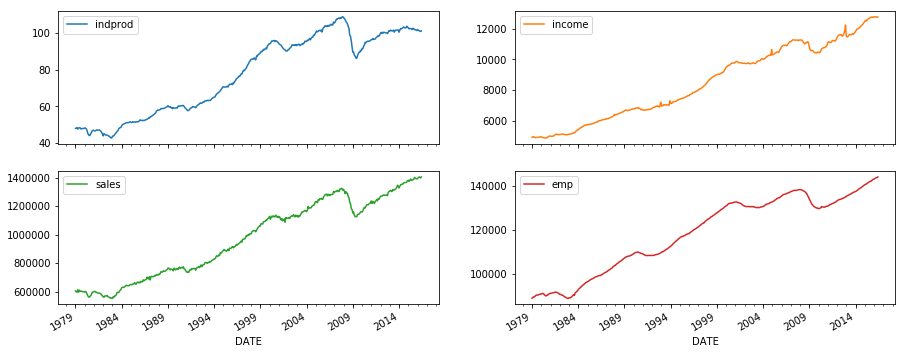

In [6]:
dta.loc[:, 'indprod':'emp'].plot(subplots=True, layout=(2, 2), figsize=(15, 6));

Stock and Watson (1991) report that for their datasets, they could not reject the null hypothesis of a unit root in each series (so the series are integrated), but they did not find strong evidence that the series were co-integrated.

As a result, they suggest estimating the model using the first differences (of the logs) of the variables, demeaned and standardized.

In [7]:
# Create log-differenced series
dta['dln_indprod'] = (np.log(dta.indprod)).diff() * 100
dta['dln_income'] = (np.log(dta.income)).diff() * 100
dta['dln_sales'] = (np.log(dta.sales)).diff() * 100
dta['dln_emp'] = (np.log(dta.emp)).diff() * 100

# De-mean and standardize
dta['std_indprod'] = (dta['dln_indprod'] - dta['dln_indprod'].mean()) / dta['dln_indprod'].std()
dta['std_income'] = (dta['dln_income'] - dta['dln_income'].mean()) / dta['dln_income'].std()
dta['std_sales'] = (dta['dln_sales'] - dta['dln_sales'].mean()) / dta['dln_sales'].std()
dta['std_emp'] = (dta['dln_emp'] - dta['dln_emp'].mean()) / dta['dln_emp'].std()

## Dynamic factors

A general dynamic factor model is written as:

$$
\begin{align}
y_t & = \Lambda f_t + B x_t + u_t \\
f_t & = A_1 f_{t-1} + \dots + A_p f_{t-p} + \eta_t \qquad \eta_t \sim N(0, I)\\
u_t & = C_1 u_{t-1} + \dots + C_1 f_{t-q} + \varepsilon_t \qquad \varepsilon_t \sim N(0, \Sigma)
\end{align}
$$

where $y_t$ are observed data, $f_t$ are the unobserved factors (evolving as a vector autoregression), $x_t$ are (optional) exogenous variables, and $u_t$ is the error, or "idiosyncratic", process ($u_t$ is also optionally allowed to be autocorrelated). The $\Lambda$ matrix is often referred to as the matrix of "factor loadings". The variance of the factor error term is set to the identity matrix to ensure identification of the unobserved factors.

This model can be cast into state space form, and the unobserved factor estimated via the Kalman filter. The likelihood can be evaluated as a byproduct of the filtering recursions, and maximum likelihood estimation used to estimate the parameters.

## Model specification

The specific dynamic factor model in this application has 1 unobserved factor which is assumed to follow an AR(2) proces. The innovations $\varepsilon_t$ are assumed to be independent (so that $\Sigma$ is a diagonal matrix) and the error term associated with each equation, $u_{i,t}$ is assumed to follow an independent AR(2) process.

Thus the specification considered here is:

$$
\begin{align}
y_{i,t} & = \lambda_i f_t + u_{i,t} \\
u_{i,t} & = c_{i,1} u_{1,t-1} + c_{i,2} u_{i,t-2} + \varepsilon_{i,t} \qquad & \varepsilon_{i,t} \sim N(0, \sigma_i^2) \\
f_t & = a_1 f_{t-1} + a_2 f_{t-2} + \eta_t \qquad & \eta_t \sim N(0, I)\\
\end{align}
$$

where $i$ is one of: `[indprod, income, sales, emp ]`.

This model can be formulated using the `DynamicFactor` model built-in to Statsmodels. In particular, we have the following specification:

- `k_factors = 1` - (there is 1 unobserved factor)
- `factor_order = 2` - (it follows an AR(2) process)
- `error_var = False` - (the errors evolve as independent AR processes rather than jointly as a VAR - note that this is the default option, so it is not specified below)
- `error_order = 2` - (the errors are autocorrelated of order 2: i.e. AR(2) processes)
- `error_cov_type = 'diagonal'` - (the innovations are uncorrelated; this is again the default)

Once the model is created, the parameters can be estimated via maximum likelihood; this is done using the `fit()` method.

**Note**: recall that we have de-meaned and standardized the data; this will be important in interpreting the results that follow.

**Aside**: in their empirical example, Kim and Nelson (1999) actually consider a slightly different model in which the employment variable is allowed to also depend on lagged values of the factor - this model does not fit into the built-in `DynamicFactor` class, but can be accomodated by using a subclass to implement the required new parameters and restrictions - see Appendix A, below.

## Parameter estimation

Multivariate models can have a relatively large number of parameters, and it may be difficult to escape from local minima to find the maximized likelihood. In an attempt to mitigate this problem, I perform an initial maximization step (from the model-defined starting paramters) using the modified Powell method available in Scipy (see the minimize documentation for more information). The resulting parameters are then used as starting parameters in the standard LBFGS optimization method.

In [9]:
# Get the endogenous data
endog = dta.loc['1979-02-01':, 'std_indprod':'std_emp']

# Create the model
mod = sm.tsa.DynamicFactor(endog, k_factors=1, factor_order=2, error_order=2)
initial_res = mod.fit(method='powell', disp=False)
res = mod.fit(initial_res.params)

## Estimates

Once the model has been estimated, there are two components that we can use for analysis or inference:

- The estimated parameters
- The estimated factor

### Parameters

The estimated parameters can be helpful in understanding the implications of the model, although in models with a larger number of observed variables and / or unobserved factors they can be difficult to interpret.

One reason for this difficulty is due to identification issues between the factor loadings and the unobserved factors. One easy-to-see identification issue is the sign of the loadings and the factors: an equivalent model to the one displayed below would result from reversing the signs of all factor loadings and the unobserved factor.

Here, one of the easy-to-interpret implications in this model is the persistence of the unobserved factor: we find that exhibits substantial persistence.

In [10]:
print(res.summary(separate_params=False))

                                             Statespace Model Results                                            
Dep. Variable:     ['std_indprod', 'std_income', 'std_sales', 'std_emp']   No. Observations:                  449
Model:                                 DynamicFactor(factors=1, order=2)   Log Likelihood               -2166.252
                                                          + AR(2) errors   AIC                           4368.504
Date:                                                   Thu, 01 Nov 2018   BIC                           4442.431
Time:                                                           20:36:59   HQIC                          4397.644
Sample:                                                       02-01-1979                                         
                                                            - 06-01-2016                                         
Covariance Type:                                                     opg                

### Estimated factors

While it can be useful to plot the unobserved factors, it is less useful here than one might think for two reasons:

1. The sign-related identification issue described above.
2. Since the data was differenced, the estimated factor explains the variation in the differenced data, not the original data.

It is for these reasons that the coincident index is created (see below).

With these reservations, the unobserved factor is plotted below, along with the NBER indicators for US recessions. It appears that the factor is successful at picking up some degree of business cycle activity.

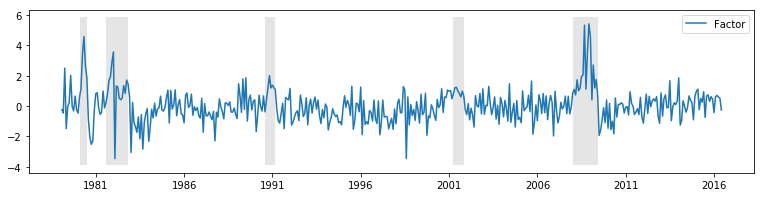

In [11]:
fig, ax = plt.subplots(figsize=(13,3))

# Plot the factor
dates = endog.index._mpl_repr()
ax.plot(dates, res.factors.filtered[0], label='Factor')
ax.legend()

# Retrieve and also plot the NBER recession indicators
rec = DataReader('USREC', 'fred', start=endog.index[0], end=end)
ylim = ax.get_ylim()
ax.fill_between(dates[:len(rec)], ylim[0], ylim[1], rec.values[:,0], facecolor='k', alpha=0.1);

## Post-estimation

Although here we will be able to interpret the results of the model by constructing the coincident index, there is a useful and generic approach for getting a sense for what is being captured by the estimated factor. By taking the estimated factors as given, regressing them (and a constant) each (one at a time) on each of the observed variables, and recording the coefficients of determination ($R^2$ values), we can get a sense of the variables for which each factor explains a substantial portion of the variance and the variables for which it does not.

In models with more variables and more factors, this can sometimes lend interpretation to the factors (for example sometimes one factor will load primarily on real variables and another on nominal variables).

In this model, with only four endogenous variables and one factor, it is easy to digest a simple table of the $R^2$ values, but in larger models it is not. For this reason, a bar plot is often employed; from the plot we can easily see that the factor explains most of the variation in industrial production index and a large portion of the variation in sales and employment, it is less helpful in explaining income.

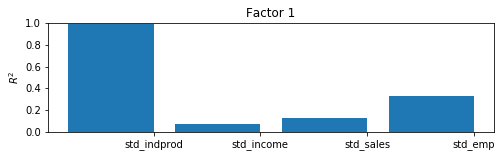

In [12]:
res.plot_coefficients_of_determination(figsize=(8,2));

## Coincident Index

As described above, the goal of this model was to create an interpretable series which could be used to understand the current status of the macroeconomy. This is what the coincident index is designed to do. It is constructed below. For readers interested in an explanation of the construction, see Kim and Nelson (1999) or Stock and Watson (1991).

In essense, what is done is to reconstruct the mean of the (differenced) factor. We will compare it to the coincident index on published by the Federal Reserve Bank of Philadelphia (USPHCI on FRED).

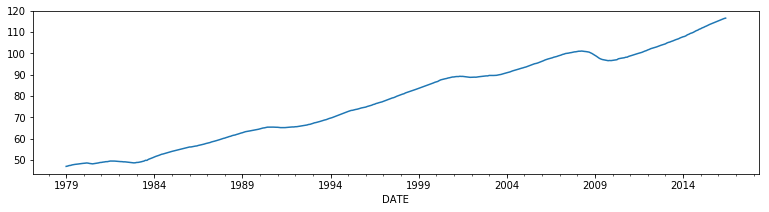

In [13]:
usphci = DataReader('USPHCI', 'fred', start='1979-01-01', end='2016-06-01')['USPHCI']
usphci.plot(figsize=(13,3));

In [14]:
dusphci = usphci.diff()[1:].values
def compute_coincident_index(mod, res):
    # Estimate W(1)
    spec = res.specification
    design = mod.ssm['design']
    transition = mod.ssm['transition']
    ss_kalman_gain = res.filter_results.kalman_gain[:,:,-1]
    k_states = ss_kalman_gain.shape[0]

    W1 = np.linalg.inv(np.eye(k_states) - np.dot(
        np.eye(k_states) - np.dot(ss_kalman_gain, design),
        transition
    )).dot(ss_kalman_gain)[0]

    # Compute the factor mean vector
    factor_mean = np.dot(W1, dta.loc['1972-02-01':, 'dln_indprod':'dln_emp'].mean())
    
    # Normalize the factors
    factor = res.factors.filtered[0]
    factor *= np.std(usphci.diff()[1:]) / np.std(factor)

    # Compute the coincident index
    coincident_index = np.zeros(mod.nobs+1)
    # The initial value is arbitrary; here it is set to
    # facilitate comparison
    coincident_index[0] = usphci.iloc[0] * factor_mean / dusphci.mean()
    for t in range(0, mod.nobs):
        coincident_index[t+1] = coincident_index[t] + factor[t] + factor_mean
    
    # Attach dates
    coincident_index = pd.Series(coincident_index, index=dta.index).iloc[1:]
    
    # Normalize to use the same base year as USPHCI
    coincident_index *= (usphci.loc['1992-07-01'] / coincident_index.loc['1992-07-01'])
    
    return coincident_index

Below we plot the calculated coincident index along with the US recessions and the comparison coincident index USPHCI.

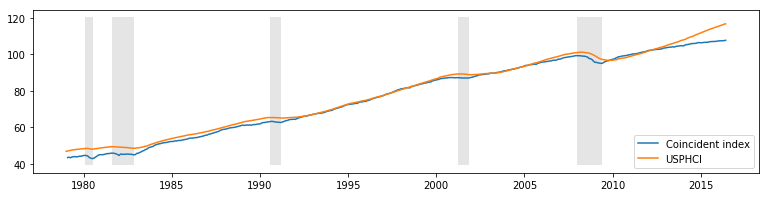

In [15]:
fig, ax = plt.subplots(figsize=(13,3))

# Compute the index
coincident_index = compute_coincident_index(mod, res)

# Plot the factor
dates = endog.index._mpl_repr()
ax.plot(dates, coincident_index, label='Coincident index')
ax.plot(usphci.index._mpl_repr(), usphci, label='USPHCI')
ax.legend(loc='lower right')

# Retrieve and also plot the NBER recession indicators
ylim = ax.get_ylim()
ax.fill_between(dates[:len(rec)], ylim[0], ylim[1], rec.values[:,0], facecolor='k', alpha=0.1);

## Appendix 1: Extending the dynamic factor model

Recall that the previous specification was described by:

$$
\begin{align}
y_{i,t} & = \lambda_i f_t + u_{i,t} \\
u_{i,t} & = c_{i,1} u_{1,t-1} + c_{i,2} u_{i,t-2} + \varepsilon_{i,t} \qquad & \varepsilon_{i,t} \sim N(0, \sigma_i^2) \\
f_t & = a_1 f_{t-1} + a_2 f_{t-2} + \eta_t \qquad & \eta_t \sim N(0, I)\\
\end{align}
$$

Written in state space form, the previous specification of the model had the following observation equation:

$$
\begin{bmatrix}
y_{\text{indprod}, t} \\
y_{\text{income}, t} \\
y_{\text{sales}, t} \\
y_{\text{emp}, t} \\
\end{bmatrix} = \begin{bmatrix}
\lambda_\text{indprod} & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
\lambda_\text{income}  & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\
\lambda_\text{sales}   & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
\lambda_\text{emp}     & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\
\end{bmatrix}
\begin{bmatrix}
f_t \\
f_{t-1} \\
u_{\text{indprod}, t} \\
u_{\text{income}, t} \\
u_{\text{sales}, t} \\
u_{\text{emp}, t} \\
u_{\text{indprod}, t-1} \\
u_{\text{income}, t-1} \\
u_{\text{sales}, t-1} \\
u_{\text{emp}, t-1} \\
\end{bmatrix}
$$

and transition equation:

$$
\begin{bmatrix}
f_t \\
f_{t-1} \\
u_{\text{indprod}, t} \\
u_{\text{income}, t} \\
u_{\text{sales}, t} \\
u_{\text{emp}, t} \\
u_{\text{indprod}, t-1} \\
u_{\text{income}, t-1} \\
u_{\text{sales}, t-1} \\
u_{\text{emp}, t-1} \\
\end{bmatrix} = \begin{bmatrix}
a_1 & a_2 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
1   & 0   & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0   & 0   & c_{\text{indprod}, 1} & 0 & 0 & 0 & c_{\text{indprod}, 2} & 0 & 0 & 0 \\
0   & 0   & 0 & c_{\text{income}, 1} & 0 & 0 & 0 & c_{\text{income}, 2} & 0 & 0 \\
0   & 0   & 0 & 0 & c_{\text{sales}, 1} & 0 & 0 & 0 & c_{\text{sales}, 2} & 0 \\
0   & 0   & 0 & 0 & 0 & c_{\text{emp}, 1} & 0 & 0 & 0 & c_{\text{emp}, 2} \\
0   & 0   & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0   & 0   & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\
0   & 0   & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
0   & 0   & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\
\end{bmatrix} 
\begin{bmatrix}
f_{t-1} \\
f_{t-2} \\
u_{\text{indprod}, t-1} \\
u_{\text{income}, t-1} \\
u_{\text{sales}, t-1} \\
u_{\text{emp}, t-1} \\
u_{\text{indprod}, t-2} \\
u_{\text{income}, t-2} \\
u_{\text{sales}, t-2} \\
u_{\text{emp}, t-2} \\
\end{bmatrix}
+ R \begin{bmatrix}
\eta_t \\
\varepsilon_{t}
\end{bmatrix}
$$

the `DynamicFactor` model handles setting up the state space representation and, in the `DynamicFactor.update` method, it fills in the fitted parameter values into the appropriate locations.

The extended specification is the same as in the previous example, except that we also want to allow employment to depend on lagged values of the factor. This creates a change to the $y_{\text{emp},t}$ equation. Now we have:

$$
\begin{align}
y_{i,t} & = \lambda_i f_t + u_{i,t} \qquad & i \in \{\text{indprod}, \text{income}, \text{sales} \}\\
y_{i,t} & = \lambda_{i,0} f_t + \lambda_{i,1} f_{t-1} + \lambda_{i,2} f_{t-2} + \lambda_{i,2} f_{t-3} + u_{i,t} \qquad & i = \text{emp} \\
u_{i,t} & = c_{i,1} u_{i,t-1} + c_{i,2} u_{i,t-2} + \varepsilon_{i,t} \qquad & \varepsilon_{i,t} \sim N(0, \sigma_i^2) \\
f_t & = a_1 f_{t-1} + a_2 f_{t-2} + \eta_t \qquad & \eta_t \sim N(0, I)\\
\end{align}
$$

Now, the corresponding observation equation should look like the following:

$$
\begin{bmatrix}
y_{\text{indprod}, t} \\
y_{\text{income}, t} \\
y_{\text{sales}, t} \\
y_{\text{emp}, t} \\
\end{bmatrix} = \begin{bmatrix}
\lambda_\text{indprod} & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
\lambda_\text{income}  & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\
\lambda_\text{sales}   & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
\lambda_\text{emp,1}   & \lambda_\text{emp,2} & \lambda_\text{emp,3} & \lambda_\text{emp,4} & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\
\end{bmatrix}
\begin{bmatrix}
f_t \\
f_{t-1} \\
f_{t-2} \\
f_{t-3} \\
u_{\text{indprod}, t} \\
u_{\text{income}, t} \\
u_{\text{sales}, t} \\
u_{\text{emp}, t} \\
u_{\text{indprod}, t-1} \\
u_{\text{income}, t-1} \\
u_{\text{sales}, t-1} \\
u_{\text{emp}, t-1} \\
\end{bmatrix}
$$

Notice that we have introduced two new state variables, $f_{t-2}$ and $f_{t-3}$, which means we need to update the  transition equation:

$$
\begin{bmatrix}
f_t \\
f_{t-1} \\
f_{t-2} \\
f_{t-3} \\
u_{\text{indprod}, t} \\
u_{\text{income}, t} \\
u_{\text{sales}, t} \\
u_{\text{emp}, t} \\
u_{\text{indprod}, t-1} \\
u_{\text{income}, t-1} \\
u_{\text{sales}, t-1} \\
u_{\text{emp}, t-1} \\
\end{bmatrix} = \begin{bmatrix}
a_1 & a_2 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
1   & 0   & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0   & 1   & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0   & 0   & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0   & 0   & 0 & 0 & c_{\text{indprod}, 1} & 0 & 0 & 0 & c_{\text{indprod}, 2} & 0 & 0 & 0 \\
0   & 0   & 0 & 0 & 0 & c_{\text{income}, 1} & 0 & 0 & 0 & c_{\text{income}, 2} & 0 & 0 \\
0   & 0   & 0 & 0 & 0 & 0 & c_{\text{sales}, 1} & 0 & 0 & 0 & c_{\text{sales}, 2} & 0 \\
0   & 0   & 0 & 0 & 0 & 0 & 0 & c_{\text{emp}, 1} & 0 & 0 & 0 & c_{\text{emp}, 2} \\
0   & 0   & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0   & 0   & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\
0   & 0   & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
0   & 0   & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\
\end{bmatrix} 
\begin{bmatrix}
f_{t-1} \\
f_{t-2} \\
f_{t-3} \\
f_{t-4} \\
u_{\text{indprod}, t-1} \\
u_{\text{income}, t-1} \\
u_{\text{sales}, t-1} \\
u_{\text{emp}, t-1} \\
u_{\text{indprod}, t-2} \\
u_{\text{income}, t-2} \\
u_{\text{sales}, t-2} \\
u_{\text{emp}, t-2} \\
\end{bmatrix}
+ R \begin{bmatrix}
\eta_t \\
\varepsilon_{t}
\end{bmatrix}
$$

This model cannot be handled out-of-the-box by the `DynamicFactor` class, but it can be handled by creating a subclass when alters the state space representation in the appropriate way.

First, notice that if we had set `factor_order = 4`, we would almost have what we wanted. In that case, the last line of the observation equation would be:

$$
\begin{bmatrix}
\vdots \\
y_{\text{emp}, t} \\
\end{bmatrix} = \begin{bmatrix}
\vdots &  &  &  &  &  &  &  &  &  &  & \vdots \\
\lambda_\text{emp,1}   & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\
\end{bmatrix}
\begin{bmatrix}
f_t \\
f_{t-1} \\
f_{t-2} \\
f_{t-3} \\
\vdots
\end{bmatrix}
$$


and the first line of the transition equation would be:

$$
\begin{bmatrix}
f_t \\
\vdots
\end{bmatrix} = \begin{bmatrix}
a_1 & a_2 & a_3 & a_4 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
\vdots &  &  &  &  &  &  &  &  &  &  & \vdots \\
\end{bmatrix} 
\begin{bmatrix}
f_{t-1} \\
f_{t-2} \\
f_{t-3} \\
f_{t-4} \\
\vdots
\end{bmatrix}
+ R \begin{bmatrix}
\eta_t \\
\varepsilon_{t}
\end{bmatrix}
$$

Relative to what we want, we have the following differences:

1. In the above situation, the $\lambda_{\text{emp}, j}$ are forced to be zero for $j > 0$, and we want them to be estimated as parameters.
2. We only want the factor to transition according to an AR(2), but under the above situation it is an AR(4).

Our strategy will be to subclass `DynamicFactor`, and let it do most of the work (setting up the state space representation, etc.) where it assumes that `factor_order = 4`. The only things we will actually do in the subclass will be to fix those two issues.

First, here is the full code of the subclass; it is discussed below. It is important to note at the outset that none of the methods defined below could have been omitted. In fact, the methods `__init__`, `start_params`, `param_names`, `transform_params`, `untransform_params`, and `update` form the core of all state space models in Statsmodels, not just the `DynamicFactor` class.

In [16]:
from statsmodels.tsa.statespace import tools
class ExtendedDFM(sm.tsa.DynamicFactor):
    def __init__(self, endog, **kwargs):
            # Setup the model as if we had a factor order of 4
            super(ExtendedDFM, self).__init__(
                endog, k_factors=1, factor_order=4, error_order=2,
                **kwargs)

            # Note: `self.parameters` is an ordered dict with the
            # keys corresponding to parameter types, and the values
            # the number of parameters of that type.
            # Add the new parameters
            self.parameters['new_loadings'] = 3

            # Cache a slice for the location of the 4 factor AR
            # parameters (a_1, ..., a_4) in the full parameter vector
            offset = (self.parameters['factor_loadings'] +
                      self.parameters['exog'] +
                      self.parameters['error_cov'])
            self._params_factor_ar = np.s_[offset:offset+2]
            self._params_factor_zero = np.s_[offset+2:offset+4]

    @property
    def start_params(self):
        # Add three new loading parameters to the end of the parameter
        # vector, initialized to zeros (for simplicity; they could
        # be initialized any way you like)
        return np.r_[super(ExtendedDFM, self).start_params, 0, 0, 0]
    
    @property
    def param_names(self):
        # Add the corresponding names for the new loading parameters
        #  (the name can be anything you like)
        return super(ExtendedDFM, self).param_names + [
            'loading.L%d.f1.%s' % (i, self.endog_names[3]) for i in range(1,4)]

    def transform_params(self, unconstrained):
            # Perform the typical DFM transformation (w/o the new parameters)
            constrained = super(ExtendedDFM, self).transform_params(
            unconstrained[:-3])

            # Redo the factor AR constraint, since we only want an AR(2),
            # and the previous constraint was for an AR(4)
            ar_params = unconstrained[self._params_factor_ar]
            constrained[self._params_factor_ar] = (
                tools.constrain_stationary_univariate(ar_params))

            # Return all the parameters
            return np.r_[constrained, unconstrained[-3:]]

    def untransform_params(self, constrained):
            # Perform the typical DFM untransformation (w/o the new parameters)
            unconstrained = super(ExtendedDFM, self).untransform_params(
                constrained[:-3])

            # Redo the factor AR unconstraint, since we only want an AR(2),
            # and the previous unconstraint was for an AR(4)
            ar_params = constrained[self._params_factor_ar]
            unconstrained[self._params_factor_ar] = (
                tools.unconstrain_stationary_univariate(ar_params))

            # Return all the parameters
            return np.r_[unconstrained, constrained[-3:]]

    def update(self, params, transformed=True, **kwargs):
        # Peform the transformation, if required
        if not transformed:
            params = self.transform_params(params)
        params[self._params_factor_zero] = 0
        
        # Now perform the usual DFM update, but exclude our new parameters
        super(ExtendedDFM, self).update(params[:-3], transformed=True, **kwargs)

        # Finally, set our new parameters in the design matrix
        self['design', 3, 1:4] = params[-3:]
        

So what did we just do?

#### `__init__`

The important step here was specifying the base dynamic factor model which we were operating with. In particular, as described above, we initialize with `factor_order=4`, even though we will only end up with an AR(2) model for the factor. We also performed some general setup-related tasks.

#### `start_params`

`start_params` are used as initial values in the optimizer. Since we are adding three new parameters, we need to pass those in. If we hadn't done this, the optimizer would use the default starting values, which would be three elements short.

#### `param_names`

`param_names` are used in a variety of places, but especially in the results class. Below we get a full result summary, which is only possible when all the parameters have associated names.

#### `transform_params` and `untransform_params`

The optimizer selects possibly parameter values in an unconstrained way. That's not usually desired (since variances can't be negative, for example), and `transform_params` is used to transform the unconstrained values used by the optimizer to constrained values appropriate to the model. Variances terms are typically squared (to force them to be positive), and AR lag coefficients are often constrained to lead to a stationary model. `untransform_params` is used for the reverse operation (and is important because starting parameters are usually specified in terms of values appropriate to the model, and we need to convert them to parameters appropriate to the optimizer before we can begin the optimization routine).

Even though we don't need to transform or untransform our new parameters (the loadings can in theory take on any values), we still need to modify this function for two reasons:

1. The version in the `DynamicFactor` class is expecting 3 fewer parameters than we have now. At a minimum, we need to handle the three new parameters.
2. The version in the `DynamicFactor` class constrains the factor lag coefficients to be stationary as though it was an AR(4) model. Since we actually have an AR(2) model, we need to re-do the constraint. We also set the last two autoregressive coefficients to be zero here.

#### `update`

The most important reason we need to specify a new `update` method is because we have three new parameters that we need to place into the state space formulation. In particular we let the parent `DynamicFactor.update` class handle placing all the parameters except the three new ones in to the state space representation, and then we put the last three in manually.

In [18]:
# Create the model
extended_mod = ExtendedDFM(endog)
initial_extended_res = extended_mod.fit(method='powell', disp=False)
extended_res = extended_mod.fit(initial_extended_res.params, maxiter=1000)
print(extended_res.summary(separate_params=False))

                                             Statespace Model Results                                            
Dep. Variable:     ['std_indprod', 'std_income', 'std_sales', 'std_emp']   No. Observations:                  449
Model:                                 DynamicFactor(factors=1, order=4)   Log Likelihood               -2150.818
                                                          + AR(2) errors   AIC                           4347.635
Date:                                                   Thu, 01 Nov 2018   BIC                           4442.097
Time:                                                           20:39:23   HQIC                          4384.869
Sample:                                                       02-01-1979                                         
                                                            - 06-01-2016                                         
Covariance Type:                                                     opg                

Although this model increases the likelihood, it is not preferred by the AIC and BIC mesaures which penalize the additional three parameters.

Furthermore, the qualitative results are unchanged, as we can see from the updated $R^2$ chart and the new coincident index, both of which are practically identical to the previous results.

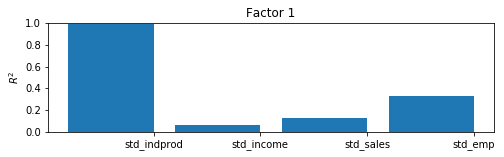

In [19]:
extended_res.plot_coefficients_of_determination(figsize=(8,2));

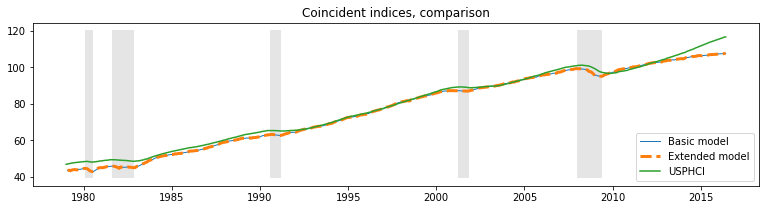

In [20]:
fig, ax = plt.subplots(figsize=(13,3))

# Compute the index
extended_coincident_index = compute_coincident_index(extended_mod, extended_res)

# Plot the factor
dates = endog.index._mpl_repr()
ax.plot(dates, coincident_index, '-', linewidth=1, label='Basic model')
ax.plot(dates, extended_coincident_index, '--', linewidth=3, label='Extended model')
ax.plot(usphci.index._mpl_repr(), usphci, label='USPHCI')
ax.legend(loc='lower right')
ax.set(title='Coincident indices, comparison')

# Retrieve and also plot the NBER recession indicators
ylim = ax.get_ylim()
ax.fill_between(dates[:len(rec)], ylim[0], ylim[1], rec.values[:,0], facecolor='k', alpha=0.1);